In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from model_utils.vital_raw_clip import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# text_config['split'] = True
# text_config['demo']['gre'] = True
# text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col_ls = ['cl_event', 'ts_description', 'demo'],#], 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother'],
    model_name = model_name,
    downsample = True,
    downsample_size = 10,
    embedded_dim = 32,
    batch_size = 2048, # Data loader settings
    patience = 10, # Training settings
    num_saves = 20,
    num_epochs = 10,
    init_lr = 1e-5,
    text_config = text_config,
    **{'3d': True}  # Add this line
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.9s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    5.5s
[Parallel(n_jobs=9)]: Done 34596 tasks      | elapsed:   10.0s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   14.5s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.    Moderate variability.  Very low amount of consecutive increases. Very high amount of consecutive unchanging values. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.5s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    8.7s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    8.8s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.    High variability.  Low amount of consecutive increases. Very high amount of consecutive unchanging values. 
After downsampling:
cl_event
This infant will die in 7 days.     384
This infant will survive.            10
Name: count, dtype: int64
After downsampling:
cl_event
This infant will die in 7 days.     241
This infant will survive.            10
Name: count, dtype: int64


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will die in 7 days.     384
This infant will survive.            10
Name: count, dtype: int64
cl_event
This infant will die in 7 days.     241
This infant will survive.            10
Name: count, dtype: int64


## Customize VITAL Model

In [5]:
# # for testing purposes
# %load_ext autoreload
# %autoreload 1
# %aimport data
# %autoreload 1
# %aimport eval

In [7]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-10,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    # torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─LocalNorm: 2-1                                                  --
│    └─Sequential: 2-2                                                 --
│    │    └─Linear: 3-1                                                77,056
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─Linear: 3-5                                                262,656
│    │    └─LeakyReLU: 3-6                                             --
│    │    └─Linear: 3-7                                                262,656
│    │    └─LeakyReLU: 3-8                                             --
│    │    └─Lin

## SOLO CLIP

In [16]:
for i in range(config_dict['num_saves']):  # n_evals
    train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                    train_dataloader,
                                                    test_dataloader, 
                                                    optimizer, 
                                                    scheduler,
                                                    kl_annealer,
                                                    num_epochs=config_dict['num_epochs'], 
                                                    train_type='clip')
    train_losses = train_losses + train_losses_tmp
    test_losses = test_losses + test_losses_tmp
    # every num_epochs, evaluate the model
    model.eval()
    if config_dict['3d']:
        train_eval_metrics = eval_clip3d_ts2txt(model, evalclipts2txt_train)
        test_eval_metrics = eval_clip3d_ts2txt(model, evalclipts2txt_test)
    else:
        train_eval_metrics = eval_clip_ts2txt(model, evalclipts2txt_train)
        test_eval_metrics = eval_clip_ts2txt(model, evalclipts2txt_test)
    train_eval_metrics_list.append(train_eval_metrics)
    test_eval_metrics_list.append(test_eval_metrics)
    eval_dict= {'train_losses': train_losses,
                'test_losses': test_losses,
                'train_evals': train_eval_metrics_list,
                'test_evals': test_eval_metrics_list }
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=False)
    print("-" * 70)
    print(f"Metric     |  Training  |  Testing")
    print("-" * 70)
    print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
    print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
    print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
    print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
    print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
    print("-" * 70)


beta: 1.0
Epoch [1/10]
	Training Loss: 7.723723
	Testing Loss: 7.253327
	Learning Rate: 0.000010000
beta: 1.0
Epoch [2/10]
	Training Loss: 7.707473
	Testing Loss: 7.253104
	Learning Rate: 0.000010000
beta: 1.0
Epoch [3/10]
	Training Loss: 7.720776
	Testing Loss: 7.239034
	Learning Rate: 0.000010000
beta: 1.0
Epoch [4/10]
	Training Loss: 7.663264
	Testing Loss: 7.231622
	Learning Rate: 0.000010000
beta: 1.0
Epoch [5/10]
	Training Loss: 7.652502
	Testing Loss: 7.235113
	Learning Rate: 0.000010000
beta: 1.0
Epoch [6/10]
	Training Loss: 7.664755
	Testing Loss: 7.225568
	Learning Rate: 0.000010000
beta: 1.0
Epoch [7/10]
	Training Loss: 7.647935
	Testing Loss: 7.211617
	Learning Rate: 0.000010000
beta: 1.0
Epoch [8/10]
	Training Loss: 7.616675
	Testing Loss: 7.210753
	Learning Rate: 0.000010000
beta: 1.0
Epoch [9/10]
	Training Loss: 7.596049
	Testing Loss: 7.202060
	Learning Rate: 0.000010000
beta: 1.0
Epoch [10/10]
	Training Loss: 7.614885
	Testing Loss: 7.193562
	Learning Rate: 0.000010000

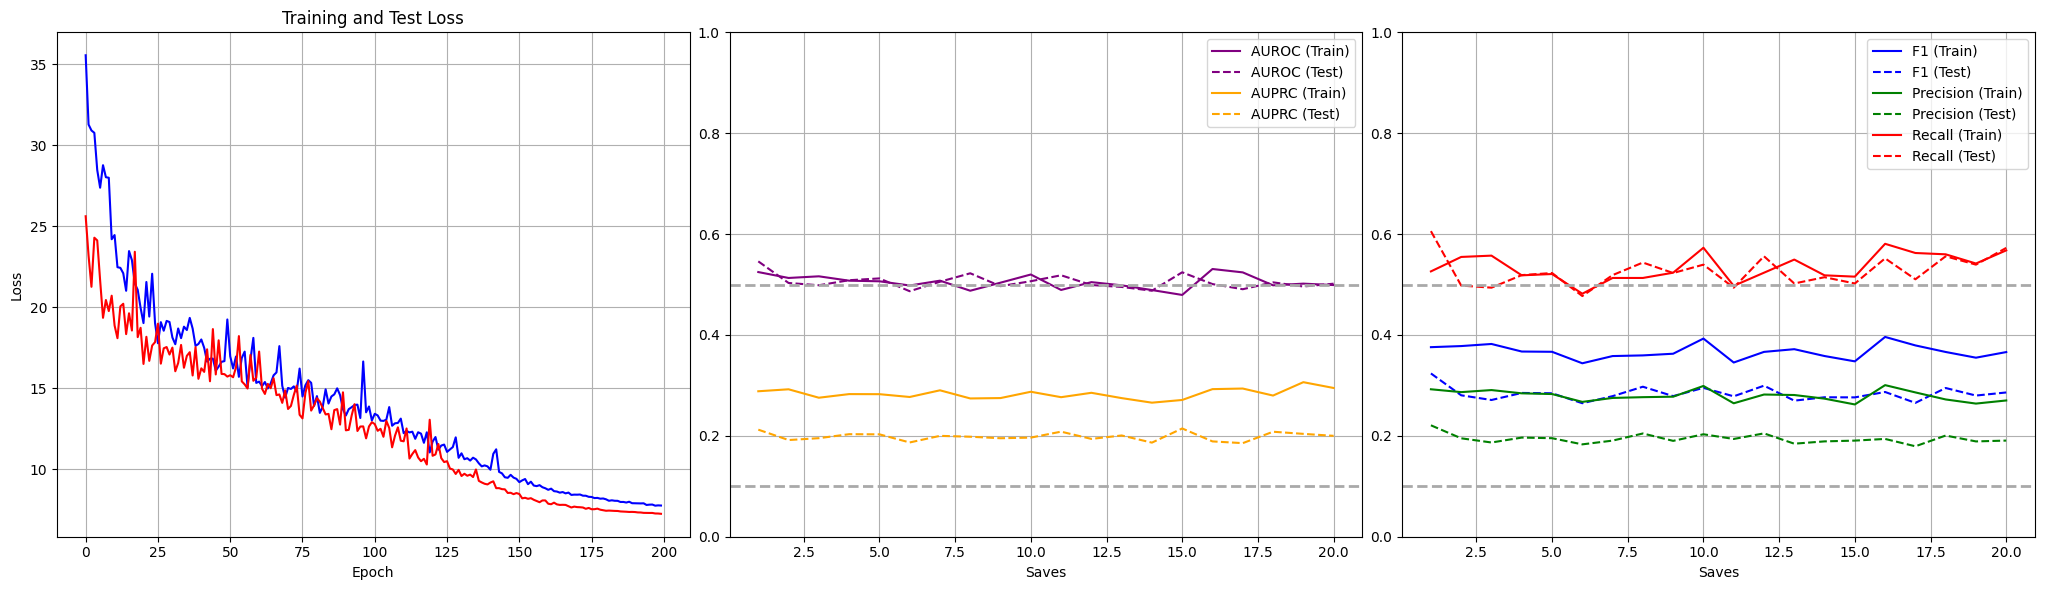

In [12]:
eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=True)

# change attention to 256
# init_lr = 1e-5

In [10]:
# txt_tsid_mapping = [['text1', 559, 560, 561],
#                         ['text2', 562, 563, 564], 
#                         ['text3', 565, 566, 832], 
#                         ['text4', 1153, 65148, 65149]]
